In [1]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from keras.utils import normalize, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Input


2023-06-13 20:08:42.520702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Exploratory Data Analysis

In [77]:
n_images = 3000

image_directory = r'../Semantic Segmentation Dataset/CameraRGB'
mask_directory = r'../Semantic Segmentation Dataset/CameraSeg'

In [83]:
train_images = []
image_files = glob.glob(os.path.join(image_directory, "*.png"))
k=1

for img_path in image_files[:n_images]:
    print(f'\rLoading Images: {k}/{n_images}', end='', flush=True)
    img = cv2.imread(img_path) 
    train_images.append(img)
    k=k+1

train_masks = [] 
print('**')
mask_files = glob.glob(os.path.join(mask_directory, "*.png"))
k=1
for mask_path in mask_files[:n_images]:
    print(f'\rLoading Masks: {k}/{n_images}', end='', flush=True)
    mask = cv2.imread(mask_path )       
    arr = np.empty(( train_images[0].shape[0] , train_images[0].shape[1] ))
    for i in range(mask.shape[1]):
        for j in range(mask.shape[0]):
            arr[j,i] = mask[j,i][2]
            
    train_masks.append(arr)    
    k=k+1

train_images = np.array(train_images)
train_masks = np.array(train_masks)

Loading Images: 3000/3000**
Loading Masks: 3000/3000

#### Image and Mask Inspection

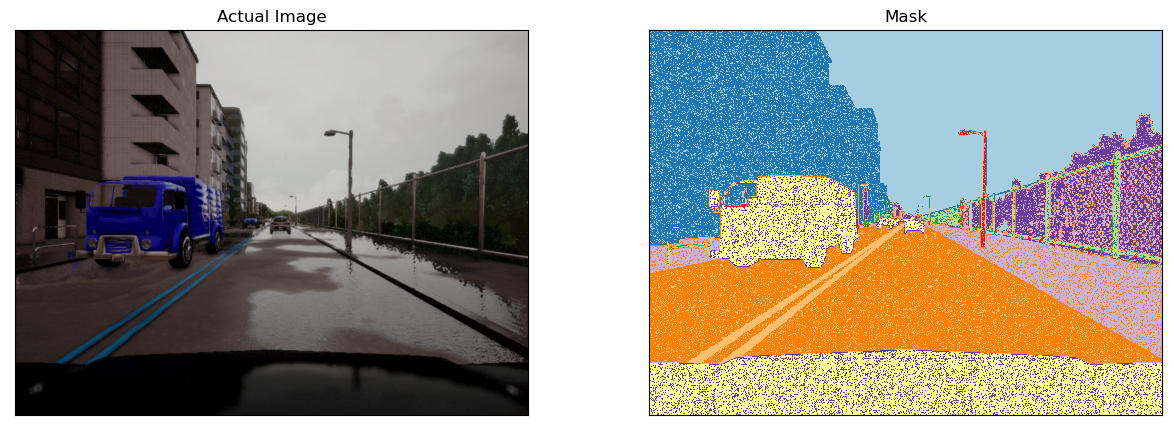

In [98]:
n = 8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(train_images[n])
axes[0].set_title("Actual Image")
axes[1].imshow(train_masks[n]  ,  cmap = "Paired")
axes[1].set_title("Mask")


predicted_mask[0, :, :].shape
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#### Analyzing Class Frequencies

In [102]:
num_classes = 13

pixel_data = pd.DataFrame(columns = [i for i in range(num_classes)] , index = range(train_masks.shape[0]))

for i in range(train_masks.shape[0]):
    y = train_masks[i]
    for j in range(0,num_classes):
        k = y[y==j]
        pixel_data[j][i] = len(k)
        
class_weights =  pixel_data.sum() / pixel_data.sum().sum()

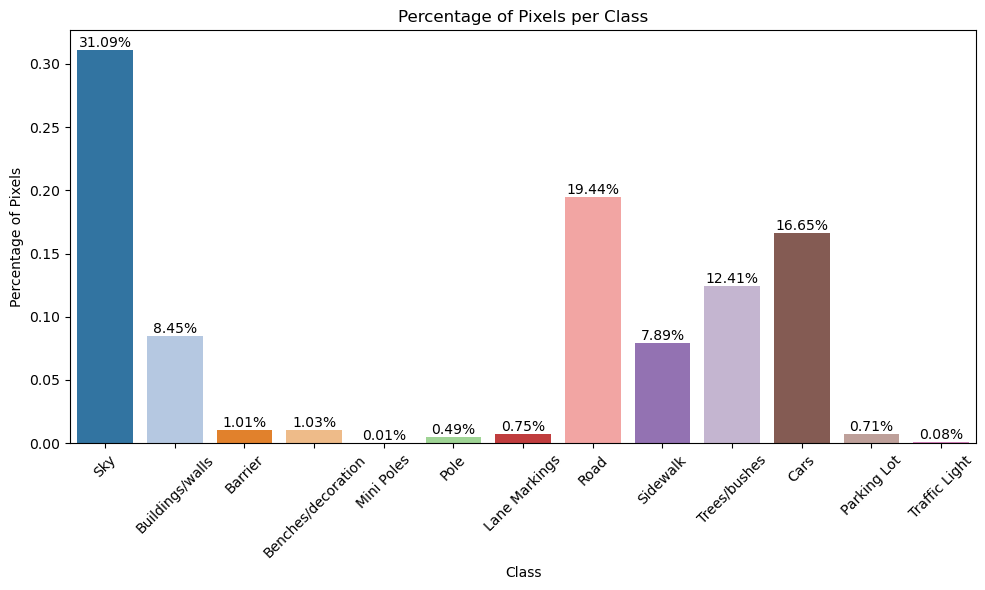

In [122]:
class_labels = ['Sky' , 'Buildings/walls', 'Barrier' , 'Benches/decoration' , 'Mini Poles' , 'Pole' , 'Lane Markings' 
                , 'Road'  , 'Sidewalk' , 'Trees/bushes' , 'Cars' , 'Parking Lot' , 'Traffic Light' ]

color_palette = sns.color_palette('tab20', len(class_weights))
plt.figure(figsize=(10, 6))


sns.barplot(x=class_labels, y=list(class_weights), palette=color_palette)

plt.xlabel('Class')
plt.ylabel('Percentage of Pixels')
plt.title('Percentage of Pixels per Class')

for i, percentage in enumerate(list(class_weights)):
    plt.text(i, percentage, f'{percentage:.2%}', ha='center', va='bottom')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Observations:**

* **Image size and resource requirements:** Images with a size of 600x800 will demand more memory and computational resources. Resizing them to a lower dimension is necessary to mitigate these resource constraints effectively.

* **Severe Class Imbalance:** The dataset exhibits a significant class imbalance, with the "Sky" class occupying 30% of the total pixels, while only 0.08% of the pixels represent the "Traffic Lights" class. Considering the importance of traffic lights, addressing this class imbalance becomes crucial for effective model training.

* **Initial simple solution:** top cropping the images: To mitigate the class imbalance, an initial solution could involve cropping the top portion of the images by 150 pixels. By reducing the presence of the sky, this approach can enhance the visibility and prominence of the traffic lights during subsequent modeling steps.

# Image Preprocessing

#### Image Acquisition, Cropping, and Resizing

In [ ]:
height = 256
width = 256
n_images = 3000
n_classes = 13

In [59]:
train_images = []
image_files = glob.glob(os.path.join(image_directory, "*.png"))
k=1

for img_path in image_files[:n_images]:
    print(f'\rLoading Images: {k}/{n_images}', end='', flush=True)
    img = cv2.imread(img_path) 
    img = img[150:, :]
    img = cv2.resize(img, ( height , width))
    train_images.append(img)
    k=k+1

train_masks = [] 
print('**')
mask_files = glob.glob(os.path.join(mask_directory, "*.png"))
k=1
for mask_path in mask_files[:n_images]:
    print(f'\rLoading Masks: {k}/{n_images}', end='', flush=True)
    mask = cv2.imread(mask_path )       
    mask = mask[150:, :]
    mask = cv2.resize(mask, (height, width), interpolation = cv2.INTER_NEAREST)  
    arr = np.empty(( width , height ))
    for i in range(mask.shape[1]):
        for j in range(mask.shape[0]):
            arr[j,i] = mask[j,i][2]
    train_masks.append(arr)    
    k=k+1
    
    
combined_list = list(zip(train_images, train_masks))
random.shuffle(combined_list)
train_images, train_masks = zip(*combined_list)

train_images=list(train_images)
train_masks=list(train_masks)

Loading Images: 3000/3000**
Loading Masks: 3000/3000

#### Data Normalization

In [60]:
train_images = np.array(train_images)
train_images_denorm = train_images.copy()
train_images = normalize(train_images, axis=3)    

#### Mask or Label Encoding

In [61]:
train_masks = np.array(train_masks)
train_masks_input = to_categorical(train_masks, num_classes=n_classes)

In [3]:
#np.save(r'../Semantic Segmentation Dataset/3000 cropped and normalized/train_masks_input.npy', train_masks_input)
#np.save(r'../Semantic Segmentation Dataset/3000 cropped and normalized/train_images.npy', train_images)

train_masks_input = np.load(r'../Semantic Segmentation Dataset/3000 cropped and normalized/train_masks_input.npy')
train_images = np.load(r'../Semantic Segmentation Dataset/3000 cropped and normalized/train_images.npy')

# Model Development

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.08 )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.086 )    

#### Definition of Evaluation Metrics

In [12]:
def mean_iou(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    num_classes = 13
    iou = []

    for i in range(num_classes):
        intersection = tf.math.count_nonzero(tf.logical_and(y_true == i, y_pred == i), dtype=tf.float32)
        union = tf.math.count_nonzero(tf.logical_or(y_true == i, y_pred == i), dtype=tf.float32)
        
        iou_value = tf.math.divide_no_nan(intersection, union)
        iou.append(tf.where(union == 0, 1.0, iou_value))
    
    mean_iou_value = tf.reduce_mean(iou)
    return mean_iou_value

def compute_and_print_class_iou(X_data, y_data, num_classes, model):
    y_pred = model.predict(X_data)
    y_pred_labels = np.argmax(y_pred, axis=-1)

    y_labels = np.argmax(y_data, axis=-1)

    class_iou = []
    for i in range(num_classes):
        intersection = np.logical_and(y_labels == i, y_pred_labels == i).sum()
        union = np.logical_or(y_labels == i, y_pred_labels == i).sum()
        if union == 0:
            iou = 1.0  # If there are no ground truth or predicted pixels for this class, set IoU as 1.0
        else:
            iou = intersection / union
        class_iou.append(iou)

    for i, iou in enumerate(class_iou):
        print(f"IoU for class {i}: {iou:.4f}")

    return class_iou


#### Architecting the U-Net Model

In [8]:
inputs = Input((256, 256, 3))

#Encoder
c0 = Conv2D(32, (3, 3), padding='same')(inputs)
c0 = BatchNormalization()(c0)
c0 = Activation('relu')(c0)
c0 = Conv2D(32, (3, 3), padding='same')(c0)
c0 = BatchNormalization()(c0)
c0 = Activation('relu')(c0)
p0 = MaxPooling2D((2, 2))(c0)


c1 = Conv2D(32*2, (3, 3), padding='same')(p0)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
c1 = Conv2D(32*2, (3, 3), padding='same')(c1)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(64*2, (3, 3), padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
c2 = Conv2D(64*2, (3, 3), padding='same')(c2)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(128*2, (3, 3), padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(128*2, (3, 3), padding='same')(c3)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(256*2, (3, 3), padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
c4 = Conv2D(256*2, (3, 3), padding='same')(c4)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)

c4_5 = Conv2D(512*2, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(c4)
c4_5 = Conv2D(512*2, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(c4_5)
c4_5 = Conv2D(512*2, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(c4_5)
p4_5 = MaxPooling2D((2, 2))(c4_5)      

# Decoder
u51 = Conv2DTranspose(256*2, (2, 2), strides=(2, 2), padding='same')(p4_5)
u51 = Concatenate()([u51, c4])
c51 = Conv2D(256*2, (3, 3), padding='same')(u51)
c51 = BatchNormalization()(c51)
c51 = Activation('relu')(c51)
c51 = Conv2D(256*2, (3, 3), padding='same')(c51)
c51 = BatchNormalization()(c51)
c51 = Activation('relu')(c51)


u5 = Conv2DTranspose(128*2, (2, 2), strides=(2, 2), padding='same')(c51)
u5 = Concatenate()([u5, c3])
c5 = Conv2D(128*2, (3, 3), padding='same')(u5)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)
c5 = Conv2D(128*2, (3, 3), padding='same')(c5)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)

u6 = Conv2DTranspose(64*2, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = Concatenate()([u6, c2])
c6 = Conv2D(64*2, (3, 3), padding='same')(u6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)
c6 = Conv2D(64*2, (3, 3), padding='same')(c6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)

u7 = Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = Concatenate()([u7, c1])
c7 = Conv2D(32*2, (3, 3), padding='same')(u7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(32*2, (3, 3), padding='same')(c7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)


u8 = Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = Concatenate()([u8, c0])
c8 = Conv2D(32*2, (3, 3), padding='same')(u8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)
c8 = Conv2D(32*2, (3, 3), padding='same')(c8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)


outputs = Conv2D(13, (1, 1), padding='same', activation='softmax')(c8)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(learning_rate=0.0001),  loss='categorical_crossentropy' , metrics=[mean_iou] )


#### Model Fitting

In [ ]:
checkpoint = ModelCheckpoint(r"../Semantic Segmentation Dataset/best_model.h5", monitor='val_mean_iou', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(X_train, y_train,
                     batch_size=8,
                     verbose=0,
                     epochs=60,
                     validation_data=(X_val, y_val),
                    callbacks = [checkpoint , early_stopping])

#### Model Evaluation and Diagnostics

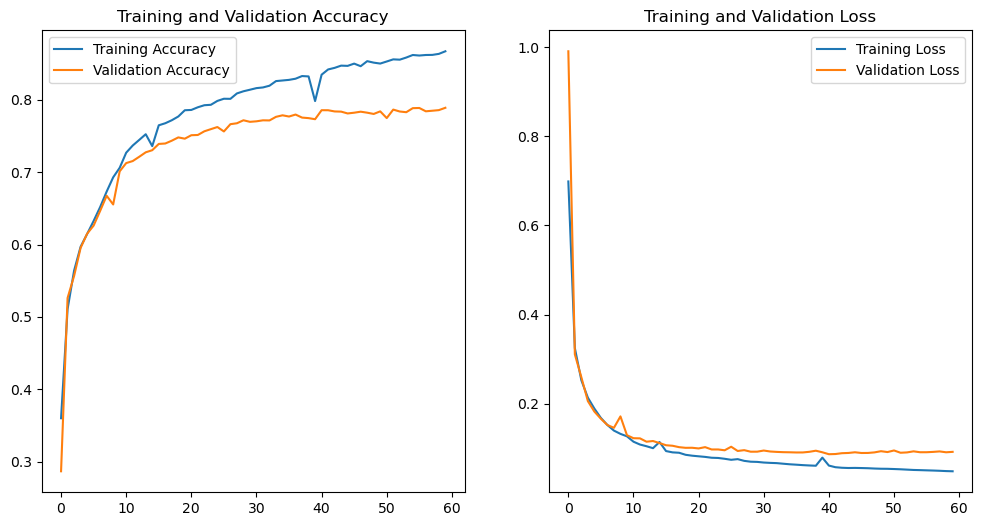

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_iou'], label='Training Accuracy')
plt.plot(history.history['val_mean_iou'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
model = load_model("../Semantic Segmentation Dataset/best_model.h5", custom_objects={'mean_iou': mean_iou})

In [7]:
IOU = compute_and_print_class_iou(X_val, y_val, n_classes , model)
print(f"Validation IOU: {np.mean(IOU):.2%}")

2023-06-13 16:36:04.988721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


8/8 [==============================] - 8s 270ms/step
IoU for class 0: 0.9368
IoU for class 1: 0.9609
IoU for class 2: 0.6996
IoU for class 3: 0.8521
IoU for class 4: 0.6464
IoU for class 5: 0.8299
IoU for class 6: 0.9478
IoU for class 7: 0.9944
IoU for class 8: 0.9756
IoU for class 9: 0.9039
IoU for class 10: 0.9942
IoU for class 11: 0.9206
IoU for class 12: 0.8262
Validation IOU: 88.37%


In [8]:
IOU = compute_and_print_class_iou(X_test, y_test, n_classes , model)
print(f"Test IOU: {np.mean(IOU):.2%}")

8/8 [==============================] - 2s 290ms/step
IoU for class 0: 0.9387
IoU for class 1: 0.9591
IoU for class 2: 0.6920
IoU for class 3: 0.8209
IoU for class 4: 0.4211
IoU for class 5: 0.8169
IoU for class 6: 0.9400
IoU for class 7: 0.9940
IoU for class 8: 0.9703
IoU for class 9: 0.9035
IoU for class 10: 0.9936
IoU for class 11: 0.9024
IoU for class 12: 0.8269
Test IOU: 86.00%


**Observation:** Minority classes had the lowest IoU. This suggests that our current model might be struggling with the class imbalance present in our data. It's an important aspect to consider for future work, as focusing on improving our model's performance on these minority classes could significantly boost overall accuracy.

# Model Inference

1/1 [==============================] - 0s 28ms/step


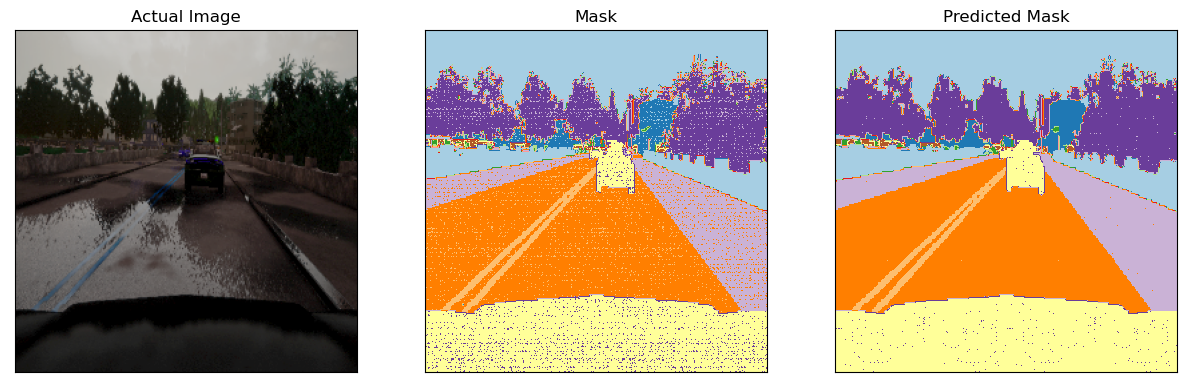

In [72]:
X_train_denorm, X_test_denorm, y_train, y_test = train_test_split(train_images_denorm, train_masks, test_size=0.08)
X_train_denorm, X_val_denorm,  y_train_d, y_val_d = train_test_split(X_train_denorm, y_train, test_size=0.086)

n = random.randint(0, len(X_val)-1)

def Predictions(n):
    test_observation = normalize(X_test_denorm , axis = 3)[n]
    test_observation = np.expand_dims(test_observation, axis=0)
    predicted_mask = model.predict(test_observation)
    predicted_mask = np.argmax(predicted_mask, axis=-1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    img = X_test_denorm[n]

    msk = y_test[n]
    axes[0].imshow(img)
    axes[0].set_title("Actual Image")
    axes[1].imshow(msk  ,  cmap = "Paired")
    axes[1].set_title("Mask")

    axes[2].imshow(predicted_mask[0, :, :] , cmap = "Paired")
    axes[2].set_title("Predicted Mask")

    predicted_mask[0, :, :].shape
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
n = random.randint(0, len(X_test)-1)
Predictions(n)

1/1 [==============================] - 0s 27ms/step


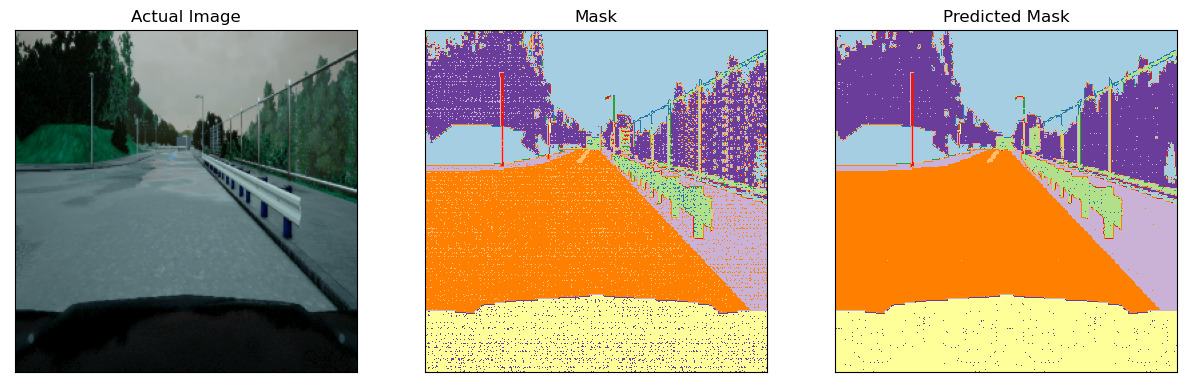

In [74]:
n = random.randint(0, len(X_test)-1)
Predictions(n)

1/1 [==============================] - 0s 26ms/step


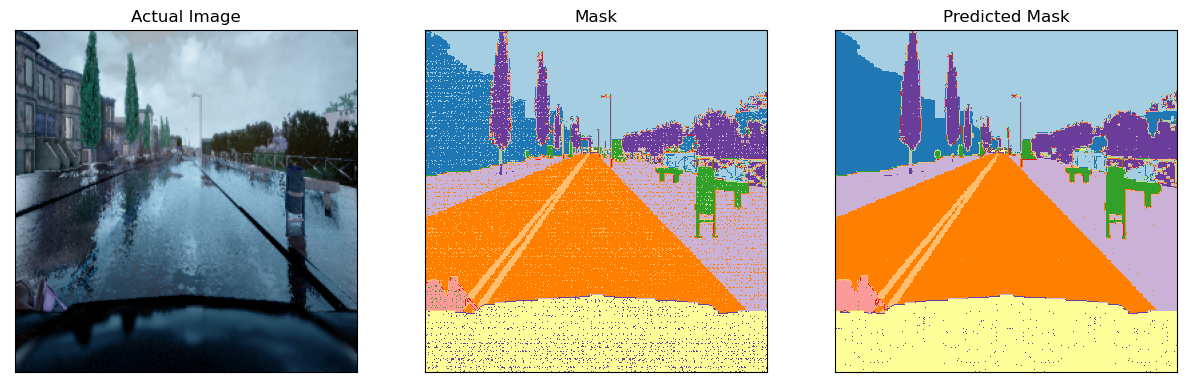

In [75]:
n = random.randint(0, len(X_test)-1)
Predictions(n)

1/1 [==============================] - 0s 24ms/step


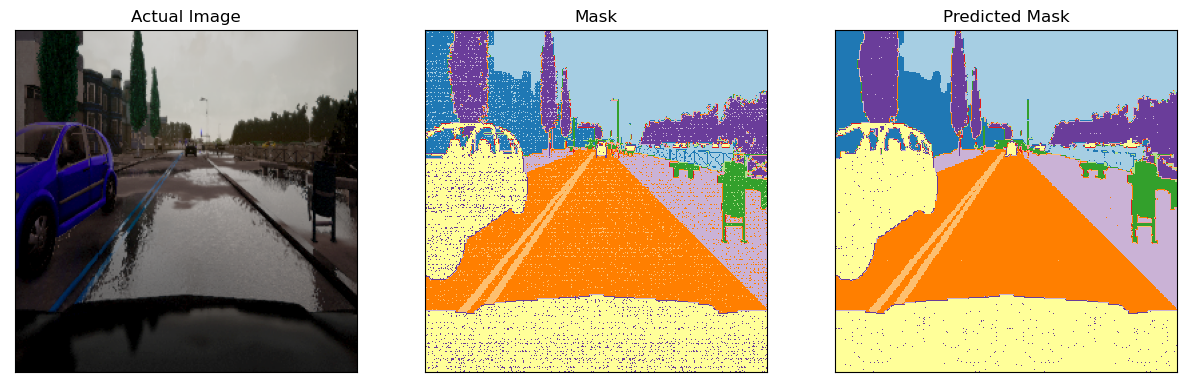

In [76]:
n = random.randint(0, len(X_test)-1)
Predictions(n)